<a href="https://colab.research.google.com/github/gagyeomkim/Deep-Learning-Paper-Review-and-Practice/blob/main/code_practice/Word2Vec1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Efficient Estimation of Word Representations in Vector Space(2013)** 실습

- 본 코드는 Word2Vec의 방법 중에서도 **Skip-Gram** 방식을 구현합니다.
    - 본 논문은 자연어 처리 기법의 기본적인 구성을 이해하고 공부하는 데에 도움을 줍니다.
- 코드 실행전에 **[런타임] -> [런타임 유형 변경]**에서 유형을 **GPU**로 설정합니다.

추가적인 reference
- http://blog.cedartrees.co.kr/index.php/category/tech-note/pytorch/
- https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/03/30/word2vec/

#### Import Modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### 데이터 전처리(Preprocessing)

- corpus 데이터를 토큰화해서 보관

In [ ]:
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',
    'seoul is korea capital',
    'bejing is china capital',
    'tokyo is japan capital',
]

def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]

    # 구조 살펴보기
    [print(f"x: {x}") for x in corpus]
    [print(f"x.split(): {x.split()}") for x in corpus]
    print(tokens)

    return tokens

tokenized_corpus = tokenize_corpus(corpus)

x: he is a king
x: she is a queen
x: he is a man
x: she is a woman
x: warsaw is poland capital
x: berlin is germany capital
x: paris is france capital
x: seoul is korea capital
x: bejing is china capital
x: tokyo is japan capital
x.split(): ['he', 'is', 'a', 'king']
x.split(): ['she', 'is', 'a', 'queen']
x.split(): ['he', 'is', 'a', 'man']
x.split(): ['she', 'is', 'a', 'woman']
x.split(): ['warsaw', 'is', 'poland', 'capital']
x.split(): ['berlin', 'is', 'germany', 'capital']
x.split(): ['paris', 'is', 'france', 'capital']
x.split(): ['seoul', 'is', 'korea', 'capital']
x.split(): ['bejing', 'is', 'china', 'capital']
x.split(): ['tokyo', 'is', 'japan', 'capital']
[['he', 'is', 'a', 'king'], ['she', 'is', 'a', 'queen'], ['he', 'is', 'a', 'man'], ['she', 'is', 'a', 'woman'], ['warsaw', 'is', 'poland', 'capital'], ['berlin', 'is', 'germany', 'capital'], ['paris', 'is', 'france', 'capital'], ['seoul', 'is', 'korea', 'capital'], ['bejing', 'is', 'china', 'capital'], ['tokyo', 'is', 'japan', '

- 단어들의 중복을 제거하여 vocabulary 리스트를 만들고
- word2idx, idx2word dict를 만들기

In [ ]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

# word -> idx
word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
print(word2idx)

# idx -> word
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}
print(idx2word)

vocabulary_size = len(vocabulary)
print(f"vocabulary_size: {vocabulary_size}")

{'he': 0, 'is': 1, 'a': 2, 'king': 3, 'she': 4, 'queen': 5, 'man': 6, 'woman': 7, 'warsaw': 8, 'poland': 9, 'capital': 10, 'berlin': 11, 'germany': 12, 'paris': 13, 'france': 14, 'seoul': 15, 'korea': 16, 'bejing': 17, 'china': 18, 'tokyo': 19, 'japan': 20}
{0: 'he', 1: 'is', 2: 'a', 3: 'king', 4: 'she', 5: 'queen', 6: 'man', 7: 'woman', 8: 'warsaw', 9: 'poland', 10: 'capital', 11: 'berlin', 12: 'germany', 13: 'paris', 14: 'france', 15: 'seoul', 16: 'korea', 17: 'bejing', 18: 'china', 19: 'tokyo', 20: 'japan'}
vocabulary_size: 21


- `window_size`를 지정하여 (중심단어, 주변단어)의 쌍을 가진 `idx_pairs` 생성

In [ ]:
window_size = 2 # 주변의 단어를 몇개까지 학습에 이용할 것인가를 결정해주는 하이퍼파라미터(양 옆 포함)
idx_pairs = []

for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence] # word -> 정수index로 변환
    # print(indices)  # (문장별로=1, 토큰개수=4)
    for center_word_pos in range(len(indices)): # (0, 1, 2, 3)으로 돌아가면서 중심단어 pos 골라짐
        for w in range(-window_size, window_size + 1):  # -2이상, 3 미만
            context_word_pos = center_word_pos + w  # 0부터 시작하는 주변 단어 index. 주변으로 윈도우크기만큼 봄.
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                # 1. 문장을 벗어나는 범위이거나
                # 2. 중심 단어랑 주변단어가 같은 경우는
                continue;
            context_word_idx = indices[context_word_pos]    # 주변 단어의 idx를 확인
            # print(context_word_idx)
            idx_pairs.append((indices[center_word_pos], context_word_idx))  # (중심단어, 주변단어) 튜플로 리스트에 넣음
            # print(idx_pairs)    # (중심단어, 주변단어) 튜플들이 리스트에 추가되는 것 확인 -> [(중심단어, 주변단어)...]
idx_pairs = np.array(idx_pairs) # 튜플들이 array로 변경됨 -> [[중심단어, 주변단어]...]
# print(idx_pairs)

> - 왜 `context_word_pos > len(indices)`이 아니라
`context_word_pos >= len(indices)`인가?
    - context_word_pos는 index이기 때문에 len(indices)-1까지만 가능함. 따라서 `> len(indices)`로 조건을 주면 out of range
    - 예를 들어, 현재 단어는 4개이지만 3이 중심단어일 경우 1 2 4만 주변 단어로 취급
        ```text
        1 2 3 4
        ```

In [ ]:
print(idx_pairs[0:10])  # 10개만 출력 / 중심단어를 통해서 -> 주변에 나올 수 있는 단어 예측하는 방법으로 학습 진행

[[0 1]
 [0 2]
 [1 0]
 [1 2]
 [1 3]
 [2 0]
 [2 1]
 [2 3]
 [3 1]
 [3 2]]


- 입력 데이터를 one-hot 형태로 변경함(`nn.Embedding`으로 구하지 않고 직접 구현)

In [ ]:
def get_input_layer(word_idx):
    # print(np.eye(vocabulary_size))  # vocabulary size만큼 Identity Matrix 생성후
    # print(np.eye(vocabulary_size)[word_idx])    # [word_idx]로 첫번째 차원(행)에서 중심 단어에 해당하는 부분만 가져옴
    return np.eye(vocabulary_size)[word_idx]    # 중심단어에 대한 원-핫 벡터 리턴

X = []
y = []
for data, target in idx_pairs:
# for data, target in idx_pairs[:5]:  #
    # data: 중심단어 인덱스
    # target: 주변단어 인덱스
    X.append(get_input_layer(data)) # 중심단어의 원핫 벡터 저장
    # print(f"X: {X}")
    y.append(target)    # 바로 주변 단어에 해당하는 정수인덱스 저장
    # print(f"y: {y}")

# print(X)
# print(y)

X = torch.FloatTensor(np.array(X))  # 텐서로 변경
y = torch.Tensor(np.array(y)).long()    # long type의 텐서로 변경
print(X)
print(y)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([ 1,  2,  0,  2,  3,  0,  1,  3,  1,  2,  1,  2,  4,  2,  5,  4,  1,  5,
         1,  2,  1,  2,  0,  2,  6,  0,  1,  6,  1,  2,  1,  2,  4,  2,  7,  4,
         1,  7,  1,  2,  1,  9,  8,  9, 10,  8,  1, 10,  1,  9,  1, 12, 11, 12,
        10, 11,  1, 10,  1, 12,  1, 14, 13, 14, 10, 13,  1, 10,  1, 14,  1, 16,
        15, 16, 10, 15,  1, 10,  1, 16,  1, 18, 17, 18, 10, 17,  1, 10,  1, 18,
         1, 20, 19, 20, 10, 19,  1, 10,  1, 20])


> - `y = torch.Tensor(np.array(y)).long()    # long type의 텐서로 변경`에서 .long 말고 .int쓰면 안되는지?
    - `nn.CrossEntropyLoss`나 `nn.NLLLoss`같은 손실함수들은 타겟값으로 long 타입의 텐서(LongTensor)를 요구하기에 .int()쓰면 런타임 에러 발생
    - nn.Embedding에서 값을 인덱싱할 때, 사용되는 텐서는 반드시 long 타입이어야함
    - 즉, 파이토치는 long 타입을 기준으로 설계되었으므로 반드시 .long 써야함

#### **Word2Vec 모듈**

In [ ]:
class Word2VecModel(nn.Module):
    def __init__(self,inout_dim):
        super().__init__()
        self.linear1 = nn.Linear(inout_dim, 2)  # (,inout_dim), -> (,2) - 2차원 벡터로 압축
        self.linear2 = nn.Linear(2, inout_dim)  # (,2) -> (,inout_dim)  - output이 되는 원-핫 벡터 생성을 위해 다시 원본 크기로 돌림

    def forward(self, x):
        return self.linear2(self.linear1(x))

print(X.size()) # (주변단어와 엮인 중심단어개수(중복 O), Vocabulary 크기)
print(X.size(dim=-1))   # (Vocabulary크기 전달)
model = Word2VecModel(X.size(dim=-1))   # inout_dim = vocabulary 크기(feature 수)로 설정

torch.Size([100, 21])
21


- nn.Linear의 선형 변환 체크

In [ ]:
m = nn.Linear(20, 30)
input = torch.randn(128, 20) # 첫번째 차원은 nn.Linear에 의해 변경되지 않음. 입력 텐서의 마지막 차원에 대해서만 선형 변환을 적용
                             # 보통 첫번째 차원은 배치크기, 마지막 차원은 feature 수를 사용함.
output = m(input)
print(output.size())

torch.Size([128, 30])


In [ ]:
m2 = nn.Linear(40, 30)
input2 = torch.randn(128, 20, 40) # 첫번째 차원은 nn.Linear에 의해 변경되지 않음. 입력 텐서의 마지막 차원에 대해서만 선형 변환을 적용
                                 # 보통 첫번째 차원은 배치크기, 마지막 차원은 feature 수를 사용함.
output2 = m2(input2)
print(output2.size())

torch.Size([128, 20, 30])


#### 학습(training)

In [ ]:
# optimizer 설정
optimizer = optim.Adam(model.parameters())

nb_epochs = 100
for epoch in range(nb_epochs + 1):  # 100번의 에폭을 돎

    # H(x) 계산
    # 훈련데이터를 다 도는게 1번의 epoch. 배치처리 안해줬으므로 한번 훈련할때마다 1번의 에폭
    prediction = model(X)   # X: (주변단어와 엮인 중심단어개수(중복 O)=100, Vocabulary크기=21) / prediction(100, 21)
    print(prediction)   # prediction은 (주변단어와 엮인 중심단어개수, 이 중심단어일 때 주변 단어 예측 점수)

    # cost 계산
    # cross_entropy함수는 softmax함수를 내부적으로 포함함.
    # cross_entropy = log_softmax + nll_loss(Negative Log Likelihood: -(y_hat - y))
    cost = F.cross_entropy(prediction, y)   # cross_entropy: 인자: (예측, 실제값)

    # cost로 H(x) 개선
    optimizer.zero_grad()   # 안넣으면?: 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch%100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

tensor([[-0.5392, -0.4769, -0.2926,  ...,  0.1269,  0.1353,  0.0157],
        [-0.5392, -0.4769, -0.2926,  ...,  0.1269,  0.1353,  0.0157],
        [-0.5990, -0.5433, -0.2732,  ...,  0.1915,  0.0990,  0.0957],
        ...,
        [-0.5684, -0.4897, -0.2949,  ...,  0.1456,  0.1346,  0.0633],
        [-0.3850, -0.3138, -0.3378,  ..., -0.0344,  0.2222, -0.1939],
        [-0.3850, -0.3138, -0.3378,  ..., -0.0344,  0.2222, -0.1939]],
       grad_fn=<AddmmBackward0>)
Epoch    0/100 Cost: 3.262854
tensor([[-0.5365, -0.4741, -0.2918,  ...,  0.1241,  0.1350,  0.0125],
        [-0.5365, -0.4741, -0.2918,  ...,  0.1241,  0.1350,  0.0125],
        [-0.5961, -0.5405, -0.2722,  ...,  0.1885,  0.0986,  0.0923],
        ...,
        [-0.5656, -0.4870, -0.2940,  ...,  0.1427,  0.1343,  0.0600],
        [-0.3826, -0.3110, -0.3374,  ..., -0.0368,  0.2218, -0.1968],
        [-0.3826, -0.3110, -0.3374,  ..., -0.0368,  0.2218, -0.1968]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.5338, -0.4713, -0.2910, 

- look-up table 연산 수행

> `model.state_dict()`: 모델의 파라미터와 버퍼를 포함한 모든 가중치를 딕셔너리 형태로 반환
- nn.Linear는 weight를 `(out_features,in_features)` 형태로 저장하므로, look-up table 연산을 위해선 transpose 시키고 사용해야함
- nn.Linear는 bias를 `(1, out_features)` 형태로 저장

In [ ]:
# look-up table 연산
# print(model.state_dict()['linear1.weight']) # W: (2, output_dim)
# print(model.state_dict()['linear1.weight'].T) # W: (output_dim, 2)

# print(model.state_dict()['linear2.weight']) # W': (output_dim, 2) <- 행을 바로 읽어오면 됨
# print(model.state_dict()['linear2.weight'].T) # W': (2, output_dim)

# print(model.state_dict()['linear1.bias']) # b: (2)
# print(model.state_dict()['linear2.bias'])   # b': (output_dim)

vector = model.state_dict()['linear1.weight'].T
# vector = model.state_dict()['linear1.weight'].T + model.state_dict()['linear1.bias'].view(-1,2)
# vector = model.state_dict()['linear2.weight'] + model.state_dict()['linear2.bias'].view(-1, 1)
w2v_df = pd.DataFrame(vector.numpy(), columns = ['임베딩벡터원소 x1', '임베딩벡터원소 x2'])
w2v_df['word'] = vocabulary
w2v_df = w2v_df[['word','임베딩벡터원소 x1','임베딩벡터원소 x2']]
w2v_df

,word,임베딩벡터원소 x1,임베딩벡터원소 x2
0,he,0.043133,0.057207
1,is,-0.041558,-0.134948
2,a,0.119008,0.122221
3,king,0.101386,-0.073457
4,she,0.022029,0.019630
5,queen,-0.079244,0.236107
6,man,0.258880,-0.025212
7,woman,-0.011290,-0.102319
8,warsaw,0.270881,0.117111
9,poland,-0.064048,-0.091271


#### **벡터간 덧셈으로 Word가 벡터로 형성되었는지 파악**

In [ ]:
test_x1 = w2v_df['임베딩벡터원소 x1'].values[6] - w2v_df['임베딩벡터원소 x1'].values[0] + w2v_df['임베딩벡터원소 x1'].values[4]
test_x2 = w2v_df['임베딩벡터원소 x2'].values[6] - w2v_df['임베딩벡터원소 x2'].values[0] + w2v_df['임베딩벡터원소 x2'].values[4]
print(test_x1, test_x2)
print(w2v_df['임베딩벡터원소 x1'].values[7], w2v_df['임베딩벡터원소 x2'].values[7])

0.23777518 -0.06278897
-0.011289637 -0.102319345


#### **시각화 예제**
ref: https://m.blog.naver.com/allieverwanted/222146678032

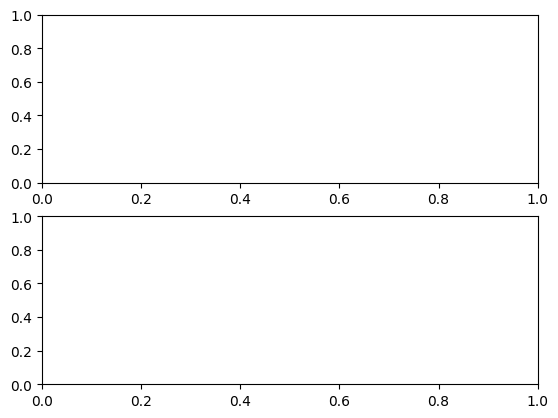

In [ ]:
# 보편적인 fig,ax = subplots()을 활용하는 방법
fig, ax = plt.subplots(2,1)
plt.show()

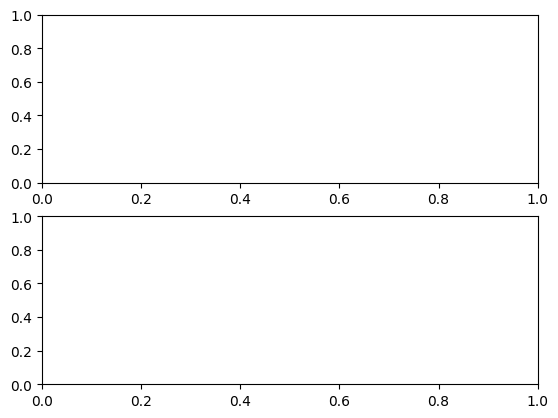

In [ ]:
# axes가 담길수 있는 figure 객체를 만들기
fig = plt.figure()

# figure에 담길 axes 만들기 [행, 열, 몇번째 axes인가?]
ax1 = fig.add_subplot(2, 1, 1)
# ax2 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 1, 2)
plt.show()

['he' 'is' 'a' 'king' 'she' 'queen' 'man' 'woman' 'warsaw' 'poland'
 'capital' 'berlin' 'germany' 'paris' 'france' 'seoul' 'korea' 'bejing'
 'china' 'tokyo' 'japan']
[ 0.04313319 -0.04155827  0.11900751  0.10138563  0.02202886 -0.07924421
  0.2588795  -0.01128964  0.27088133 -0.06404826  0.26108873  0.25483462
 -0.09115453  0.00638777 -0.0429658   0.29319844 -0.08152222  0.09796954
  0.30394104 -0.12686506  0.06872483]
[ 0.05720696 -0.13494752  0.12222149 -0.07345726  0.01962962  0.23610723
 -0.02521163 -0.10231934  0.11711135 -0.09127066  0.28074178  0.08383697
  0.12340941  0.2675957  -0.09685888  0.17500794 -0.02352973  0.09643777
 -0.10682783  0.17654942 -0.03630592]


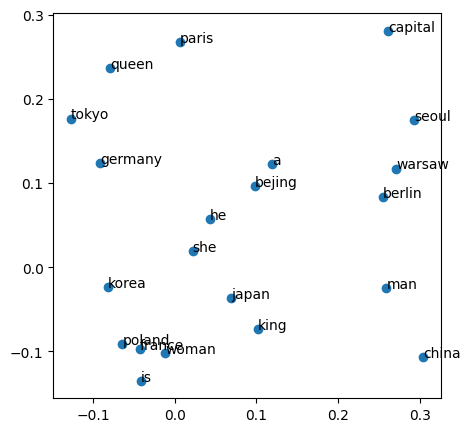

In [ ]:
ano = w2v_df['word'].values
print(ano)
x1 = w2v_df['임베딩벡터원소 x1'].values
print(x1)
x2 = w2v_df['임베딩벡터원소 x2'].values
print(x2)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x1, x2)  # 두 변수의 상관 관계를 직교 좌표계의 평면에 점으로 표현하는 그래프

for i, txt in enumerate(ano):
    ax.annotate(txt, (x1[i],x2[i])) # 특정 위치에 주석(annotation)을 추가하는 데 사용